In [ ]:
#@title NoteBook Parameters
RAND_IMGS   = '/content/drive/MyDrive/Brandon/pixel-art-pinterest-001.zip' # Path of the zip/folder for random dataset ex : 'pixel-art-pinterest-001.zip'
TAGGED_IMGS = '/content/drive/MyDrive/Brandon/pixel-art-tagged.zip' # Path of the tagged dataset zip/folder ex : 'pixel-art-tagged.zip'  


In [ ]:
#@title Imports
import torch
import torchvision
import os
import open_clip
from torch.utils.data import DataLoader
import numpy as np
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from PIL import Image
import hashlib
import json
from pathlib import Path
from json import JSONEncoder
import random
from sklearn.datasets import load_wine
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from ascii_graph import Pyasciigraph
from torch.utils.data import ConcatDataset

In [ ]:
#@title  CLIP Model 
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32',pretrained='openai')
device = "cuda" if torch.cuda.is_available() else "cpu"

100%|████████████████████████████████████████| 354M/354M [00:03<00:00, 110MiB/s]


In [ ]:
#@title Helper Functions

def convert_gif_to_image(gif_path):
  """ Delets the GIF and change it with first frame .png image  """
  im  = Image.open(gif_path)
  dir_path = os.path.dirname(os.path.abspath(gif_path))
  im.seek(0)
  im_file = os.path.basename(gif_path).split('.gif')[0]
  save_path = os.path.join(dir_path ,f'{im_file}.png' )
  im.save(save_path) # save the first frame as .png image 
  !rm -r $gif_path # Delete the .gif file 

def from_img_to_hash(img_file):
  """returns sha256 of the image file """
  file_obj = open(img_file,"rb")
  bytes = file_obj.read() # read entire file as bytes
  return hashlib.sha256(bytes).hexdigest()

# https://github.com/openai/CLIP#linear-probe-evaluation
def get_features(dataset):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=20 ,shuffle=True):
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).detach().numpy(), torch.cat(all_labels).detach().numpy()


def folder_to_featureList(folder_path):
  """ This takes a folder and returns a list of CLIP features to this folder """
  all_features = []

  with torch.no_grad():
      for img_file in os.listdir(folder_path):
        try:
          image_file_path = os.path.join(folder_path , img_file)
          image = preprocess(Image.open(image_file_path)).unsqueeze(0).to(device)
          all_features.append(model.encode_image(image).detach().numpy())
        except :
          print(f"[Warning] Problem with file {img_file}")
          continue

  return all_features

def histogram_list(image_featurs_list, reg_model , idx_class_map):
  """ This function takes folder and returns histogram lists
      (histogram list for inbounding) ,, (histogram lit for outbounding)
       
  :fimage_featurs_list: list of all images' features of the hist folder 
  :model: the model which we get the results from make sure that it has '.predict_proba' method
  :index_class_map: mapping between index and the class 
  """
  hist_dict_0 = {'0.1' : 0 ,'0.2' : 0 ,
                 '0.3' : 0 ,'0.4':0 ,
                 '0.5' : 0 ,'0.6':0 ,
                 '0.7' : 0 ,'0.8':0 ,
                 '0.9' : 0 ,'1.0':0 ,
                 } # dictionary of histogram values 
  
  hist_dict_1 = {'0.1' : 0 ,'0.2' : 0 ,
                 '0.3' : 0 ,'0.4':0 ,
                 '0.5' : 0 ,'0.6':0 ,
                 '0.7' : 0 ,'0.8':0 ,
                 '0.9' : 0 ,'1.0':0 ,
                 } # dictionary of histogram values 
  
  for image_features in image_featurs_list:
    prob_0 = reg_model.predict_proba(image_features)[0][0]
    prob_1 = reg_model.predict_proba(image_features)[0][1]
   
    # Choosing the bin of the image for index 0 
    if 0.0 <= prob_0 <= 0.1 : 
      hist_dict_0['0.1'] += 1
    elif 0.1 < prob_0 <= 0.2 : 
      hist_dict_0['0.2'] += 1
    elif 0.3 < prob_0 < 0.4 : 
      hist_dict_0['0.3'] += 1
    elif 0.4 <= prob_0 < 0.5 : 
      hist_dict_0['0.4'] += 1
    elif 0.5 <= prob_0 < 0.6 : 
      hist_dict_0['0.5'] += 1
    elif 0.6 <= prob_0 < 0.7 : 
      hist_dict_0['0.6'] += 1
    elif 0.7 <= prob_0 < 0.8 : 
      hist_dict_0['0.7'] += 1
    elif 0.8 <= prob_0 < 0.9 : 
      hist_dict_0['0.8'] += 1
    elif 0.9 <= prob_0 < 1.0 : 
      hist_dict_0['0.9'] += 1
    elif prob_0 == 1.0 : 
      hist_dict_0['1.0'] += 1 
   
    # Choosing the bin of the image for index 0 
    if 0.0 <= prob_1 <= 0.1 : 
      hist_dict_1['0.1'] += 1
    elif 0.1 < prob_1 <= 0.2 : 
      hist_dict_1['0.2'] += 1
    elif 0.3 < prob_1 < 0.4 : 
      hist_dict_1['0.3'] += 1
    elif 0.4 <= prob_1 < 0.5 : 
      hist_dict_1['0.4'] += 1
    elif 0.5 <= prob_1 < 0.6 : 
      hist_dict_1['0.5'] += 1
    elif 0.6 <= prob_1 < 0.7 : 
      hist_dict_1['0.6'] += 1
    elif 0.7 <= prob_1 < 0.8 : 
      hist_dict_1['0.7'] += 1
    elif 0.8 <= prob_1 < 0.9 : 
      hist_dict_1['0.8'] += 1
    elif 0.9 <= prob_1 < 1.0 : 
      hist_dict_1['0.9'] += 1
    elif prob_1 == 1.0 : 
      hist_dict_1['1.0'] += 1 

  if idx_class_map[0] == 'other' :  
    return  [(key , hist_dict_1[key]) for key in hist_dict_1] , [(key , hist_dict_0[key]) for key in hist_dict_0]
  
  return  [(key , hist_dict_0[key]) for key in hist_dict_0] , [(key , hist_dict_1[key]) for key in hist_dict_1]

def from_labels_to_count(labels , idx_class_map):
  """ Returns tag count , other count """
  index_0 = np.count_nonzero(labels == 0)
  index_1 = np.count_nonzero(labels == 1)
  if idx_class_map[0] == 'other':
    return index_1 , index_0
  return index_0 , index_1

def clean_file(file_path):
  """ This function takes a file path and see if it is supported or not 
    :file_path: path of the file to work with 
  """
  if file_path.lower().endswith('.gif'): # If it's GIF then convert to image and exit 
    try : 
      convert_gif_to_image(file_path)
    except:
      print(f"[Warning] problem with {file_path}")
      if os.path.exists(file_path):
        print(f"[Warning] removing {file_path}")
        !rm $file_path
    return 

  # if it's not gif and not a supprted file type then remove it 
  if not file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')):
    !rm $file_path
    print(f'[Removing] {file_path}')
    return 

def clean_directory(dir_path , only_sub_dir = False):
  """ Clean a directory 
      -- check if it has directory or image 
      -- take action based on this 
     :dir_path: path of the directory to be cleaned 
     :only_sub_dir: key for having only sub dirs not sub files 
                    for example in 'pixel-art-tagged'
  """
  for dir in os.listdir(dir_path):
    sub_dir = os.path.join(dir_path, dir)
    
    if os.path.isfile(sub_dir): # if it's a file then clean the file  
      
      if only_sub_dir : # no subfiles allowed for example in the pixel-art-tagged 
        !rm  $sub_dir 
        print(f"[Removing] {sub_dir}")
        continue 
      clean_file(sub_dir)
      continue

    if len(os.listdir(sub_dir)) == 0: # Empty folder, delte it 
      !rm -r $sub_dir 
      print(f'[Removing] {sub_dir}')
      continue

    if os.path.isdir(sub_dir):
      clean_directory(sub_dir)



In [ ]:
#@title Unzipping/Copying The Random Images and Tagged Images 
%%capture 

CURR_DIR = os.getcwd() # get the current directory 

if RAND_IMGS.endswith('.zip'): # It's a zip file 
  !unzip $RAND_IMGS -d $CURR_DIR 
  RAND_IMGS = os.path.join(CURR_DIR , os.path.basename(os.path.normpath(RAND_IMGS)).split('.zip')[0])
else: # It's a folder 
  !cp -r $RAND_IMGS -d $CURR_DIR 
  RAND_IMGS = os.path.join(CURR_DIR , os.path.basename(os.path.normpath(RAND_IMGS)))

if TAGGED_IMGS.endswith('.zip'): # It's a zip file 
  !unzip $TAGGED_IMGS -d $CURR_DIR
  TAGGED_IMGS = os.path.join(CURR_DIR , os.path.basename(os.path.normpath(TAGGED_IMGS)).split('.zip')[0])

else: # It's a folder 
  !cp -r $TAGGED_IMGS -d $CURR_DIR 
  TAGGED_IMGS = os.path.join(CURR_DIR , os.path.basename(os.path.normpath(TAGGED_IMGS)))


In [ ]:
# Cleaning the pinterest--001 directory 
clean_directory(RAND_IMGS)

# Cleaning the tagged directory 
clean_directory(TAGGED_IMGS , only_sub_dir=True)

[Warning] problem with /content/pixel-art-pinterest-001/https___i.pinimg.com_originals_f9_5a_67_f95a675e1cffe92fe4e8e9aabef71e8d.gif
[Warning] removing /content/pixel-art-pinterest-001/https___i.pinimg.com_originals_f9_5a_67_f95a675e1cffe92fe4e8e9aabef71e8d.gif
[Removing] /content/pixel-art-tagged/pos-pixel-art-bad
[Removing] /content/pixel-art-tagged/not-pixel-art/00006-32x32_100k_patches-mirror-auto1.zip
[Removing] /content/pixel-art-tagged/note.txt


In [ ]:
#@title Generating "other" Folder and "binary datasets" Folder to Train on. 
random.seed(10) # seed for re-generation the same every time 

# files list of the RAND_IMGS folder (used for generating "other" folder)
rand_folder_files_list = [os.path.join(RAND_IMGS , file_name) for file_name in os.listdir(RAND_IMGS)]

# creating the binar folder for the classification dataset
new_binary_directory = os.path.join(CURR_DIR , 'pixel-art-binary')
os.makedirs(new_binary_directory , exist_ok=True)

# creating "other" folder to be used in training the classifiers 
other_folder  = os.path.join(CURR_DIR , 'other')
os.makedirs(other_folder , exist_ok=True) # make the other folder to put chosen images in it 

# Creatig the "other" folder  
taken_files_hash = []
taken_files_paths= []
while len(taken_files_hash) < (len(rand_folder_files_list)//10) : # only take 10% of the RAND_IMGS folder 
  rand_idx   = random.randint( 0 , len(rand_folder_files_list)-1)
  image_path = rand_folder_files_list[rand_idx]
  image_hash = from_img_to_hash(image_path)
  if image_hash not in taken_files_hash:
    taken_files_hash.append(image_hash)
    taken_files_paths.append(image_path)
    !cp $image_path $other_folder

# Put every class directory in binary-folder (to train the classifers on)
for dir in os.listdir(TAGGED_IMGS):
  tag_dir = os.path.join(TAGGED_IMGS ,dir)
  bin_tag_dir = os.path.join(new_binary_directory , f'{dir}-binary')
  os.makedirs(bin_tag_dir , exist_ok=True)
  !cp -r $tag_dir $bin_tag_dir
  !cp -r $other_folder $bin_tag_dir


In [ ]:
 #@title Generating "other-validation" Folder for Calculating Histogram

random.seed(20) # seed for re-generation the same every time 

other_validation_folder  = os.path.join(CURR_DIR, 'other-validation')
os.makedirs(other_validation_folder , exist_ok=True) # make the "other validation folder "

## make the others folder here 
taken_files_hash = []
taken_files_paths= []

while len(taken_files_hash) < (len(rand_folder_files_list)//10) :
  rand_idx   = random.randint( 0 , len(rand_folder_files_list)-1)
  image_path = rand_folder_files_list[rand_idx]
  image_hash = from_img_to_hash(image_path)
  if image_hash not in taken_files_hash:
    taken_files_hash.append(image_hash)
    taken_files_paths.append(image_path)
    !cp $image_path $other_folder


In [ ]:
#@title calculating histogram folder images' features
## To calculate it once and then re-use it
hist_folder_features = folder_to_featureList(other_validation_folder)

[Warning] Problem with file https___i.pinimg.com_originals_f7_db_27_f7db273640ab48a0c420f4debf14d7bb.png


Test images of tagged set  1
Map index {0: 'other', 1: 'pos-character'}
test list [542, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Accuracy = 96.2963
Finished pos-character tag
Test images of tagged set  1
Map index {0: 'other', 1: 'pos-environment-space'}
test list [536, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
Accuracy = 98.1132
Finished pos-environment-space tag
Test images of tagged set  1
Map index {0: 'other', 1: 'pos-video-game'}
test list [550, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Accuracy = 98.1818
Fi

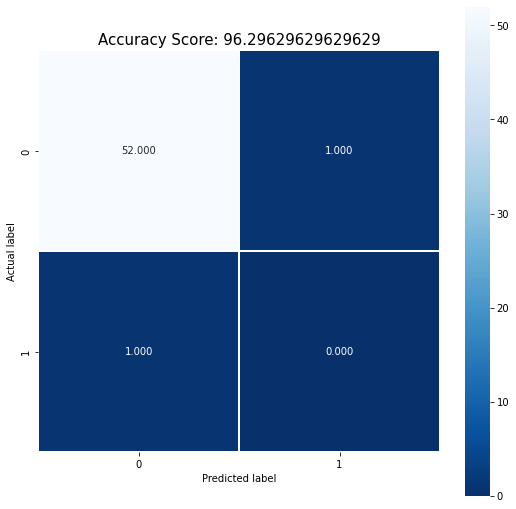

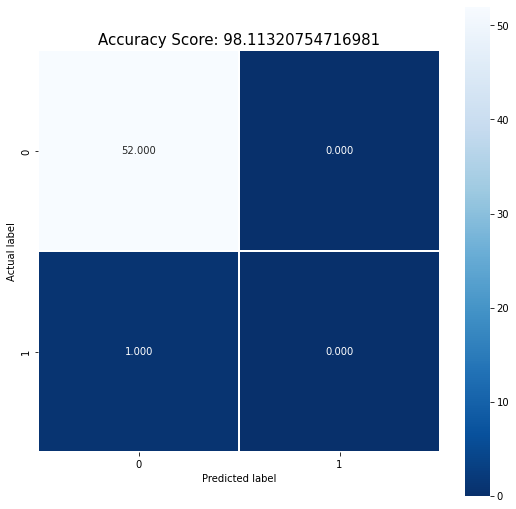

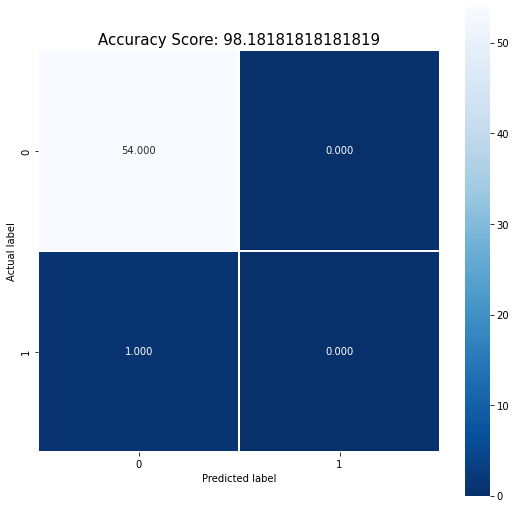

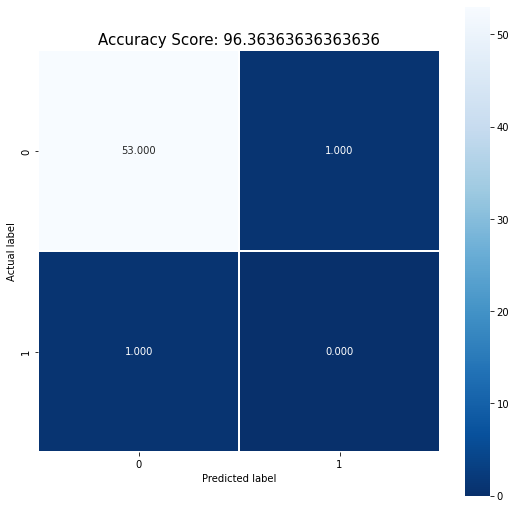

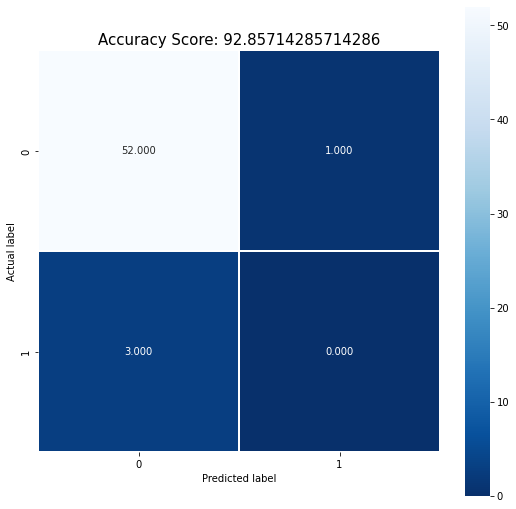

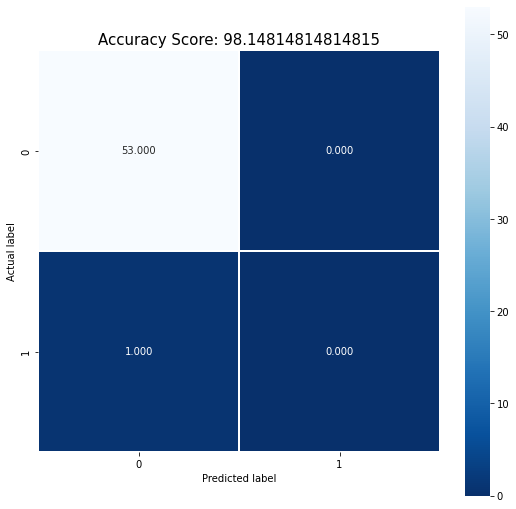

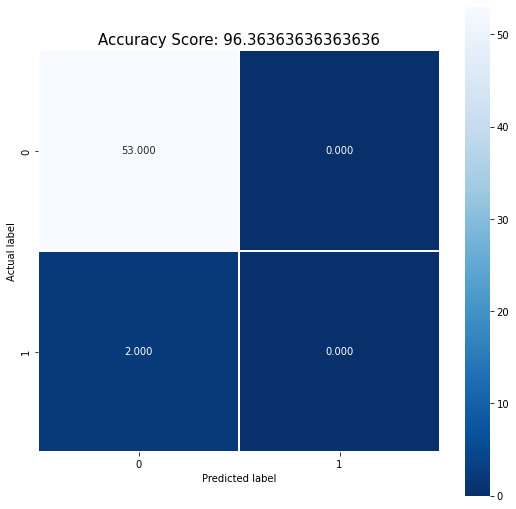

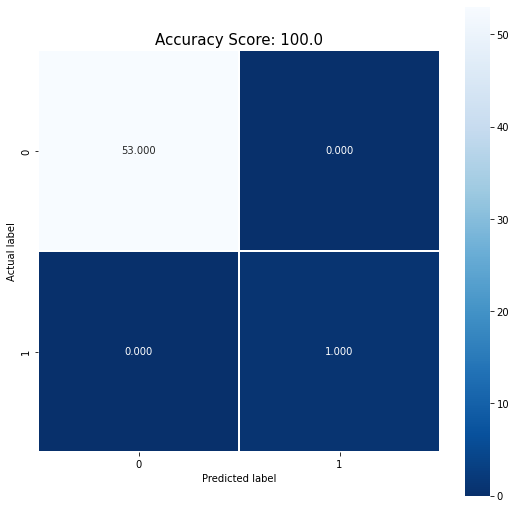

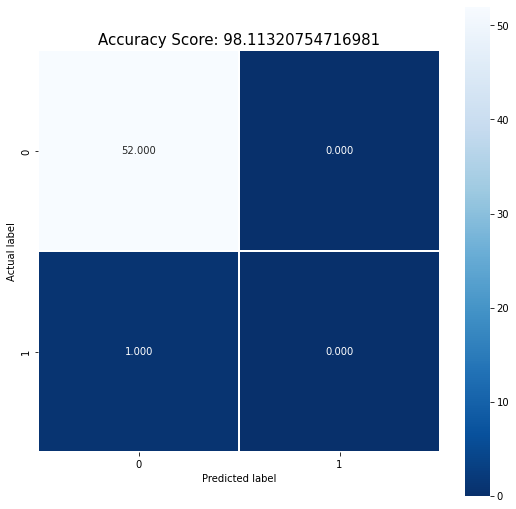

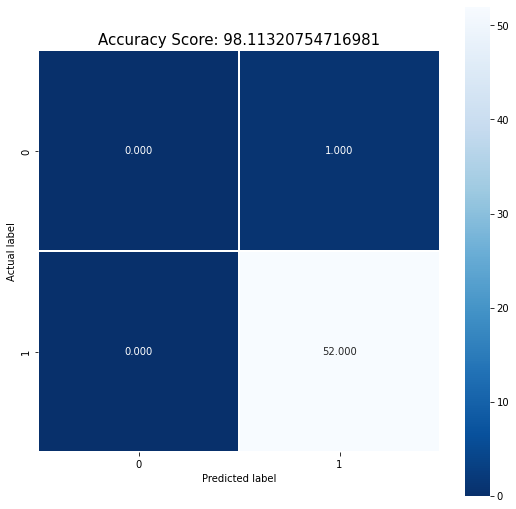

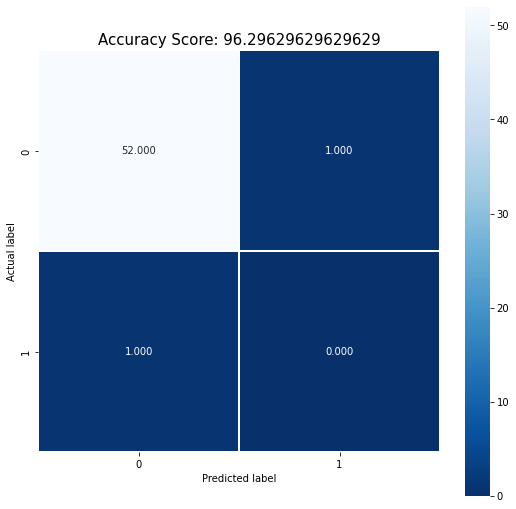

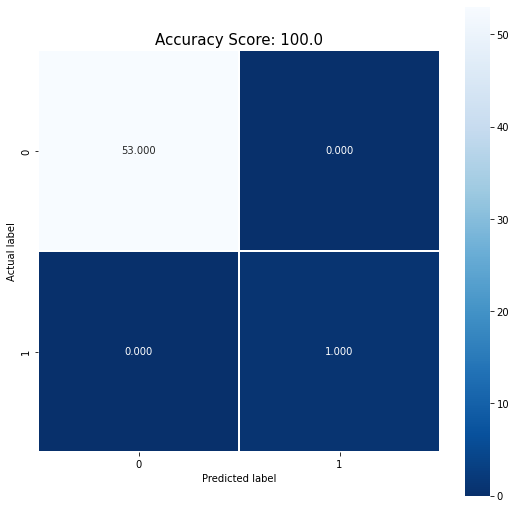

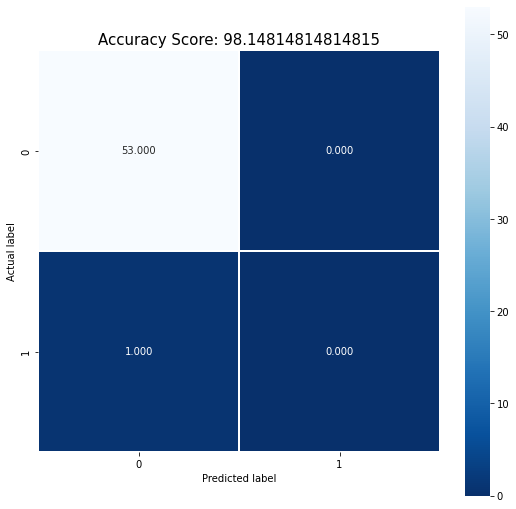

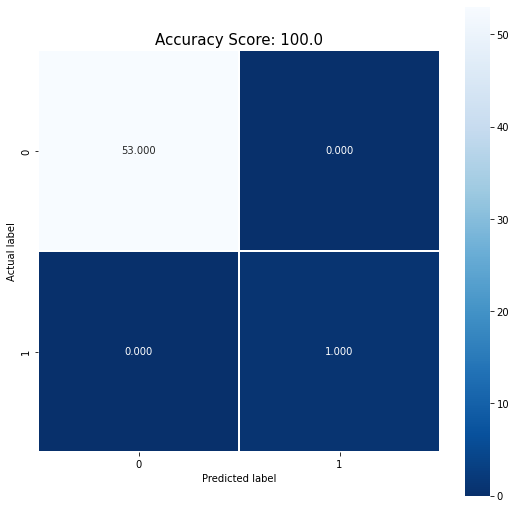

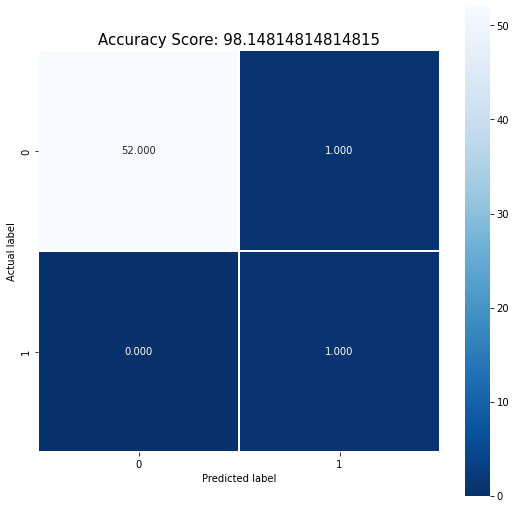

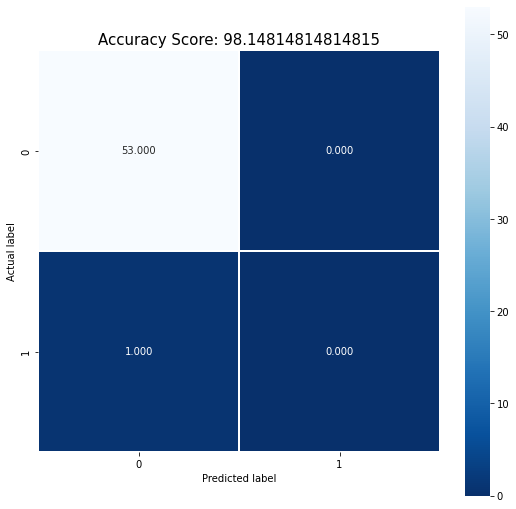

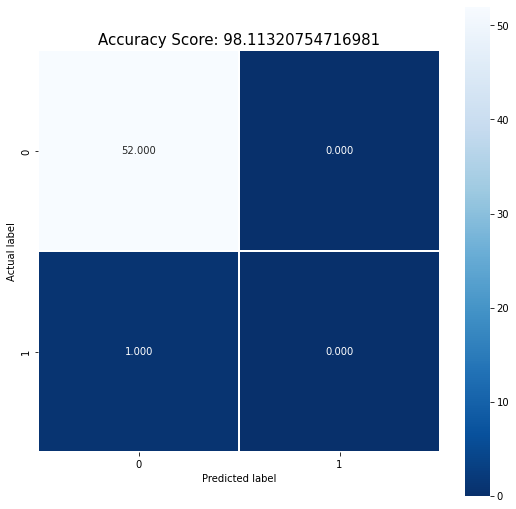

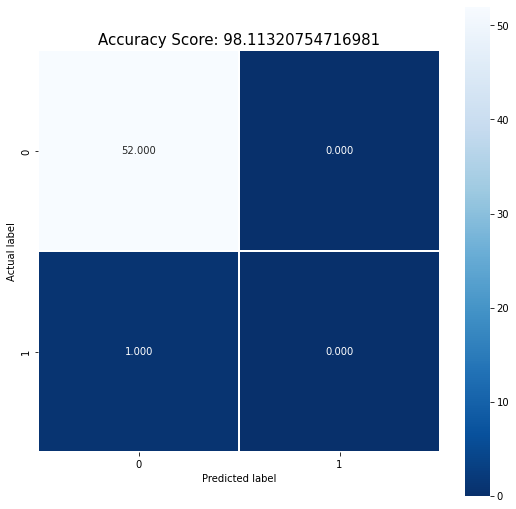

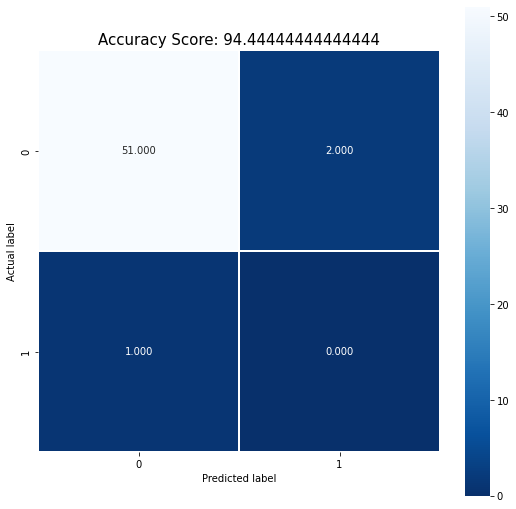

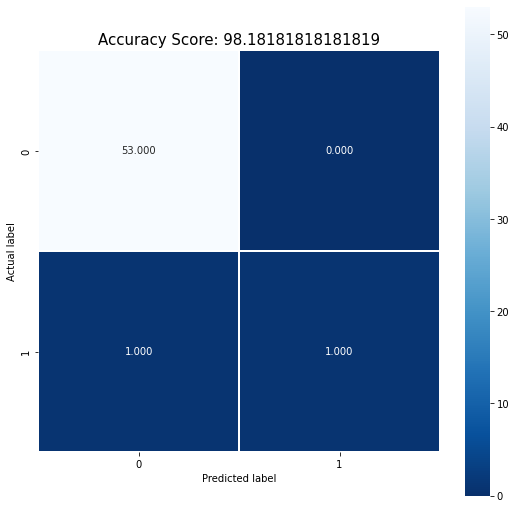

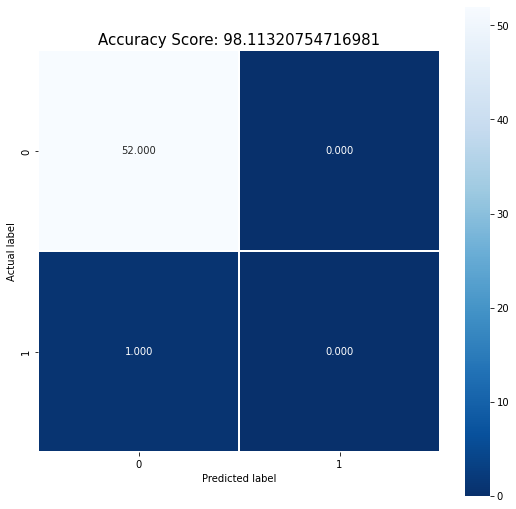

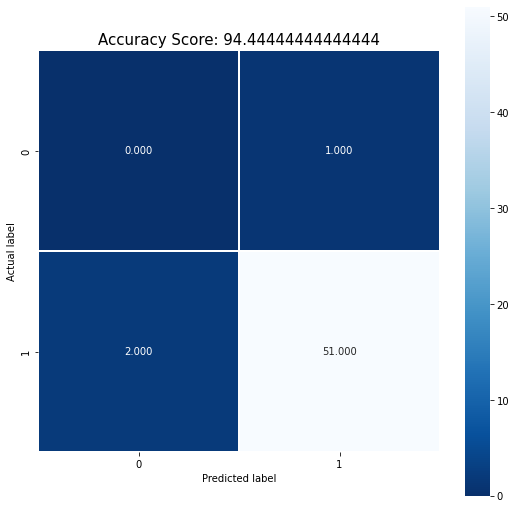

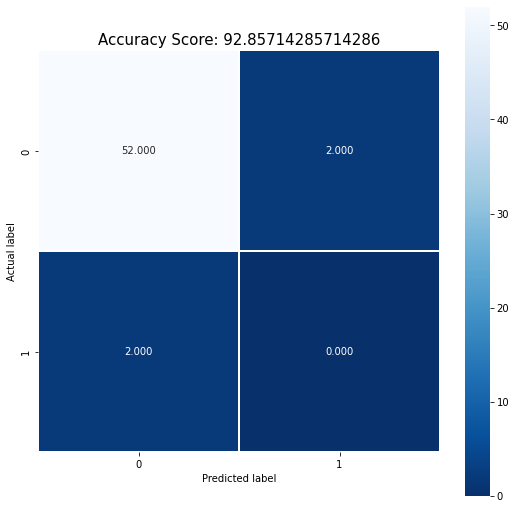

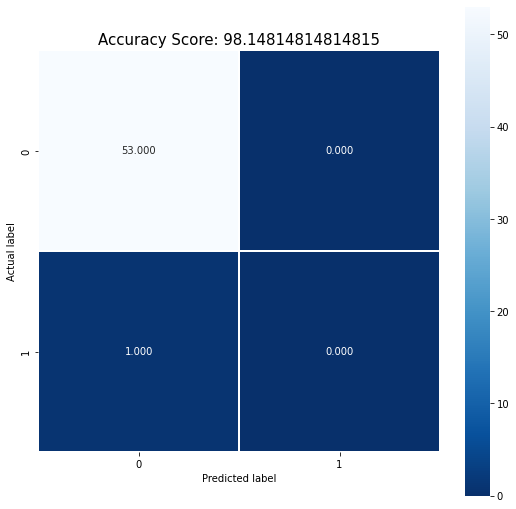

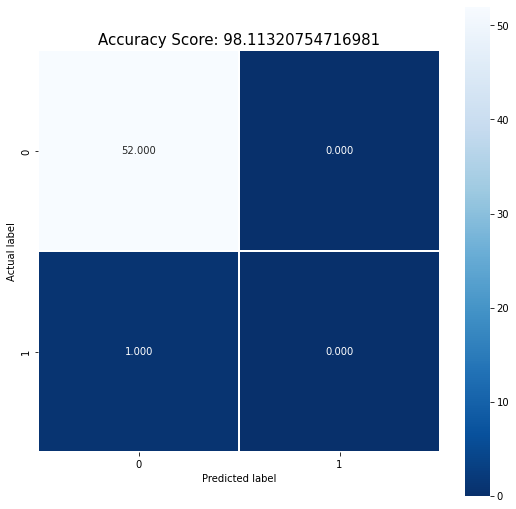

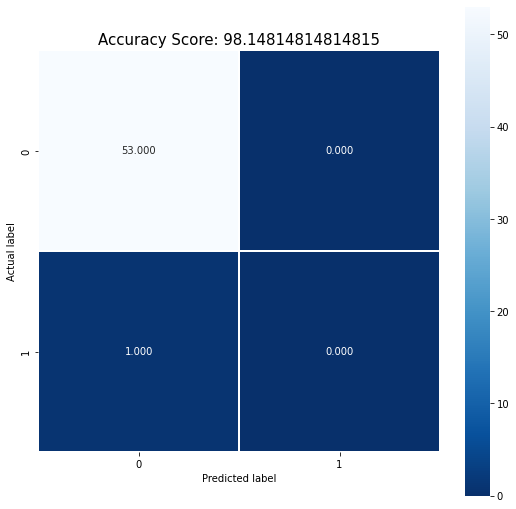

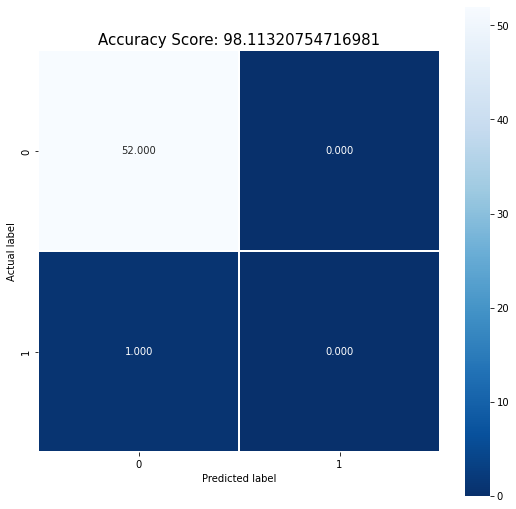

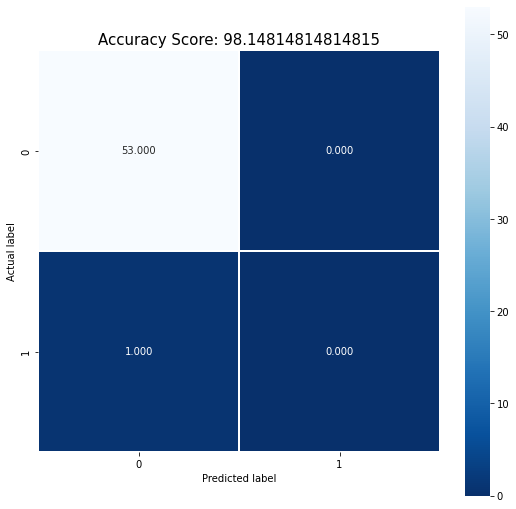

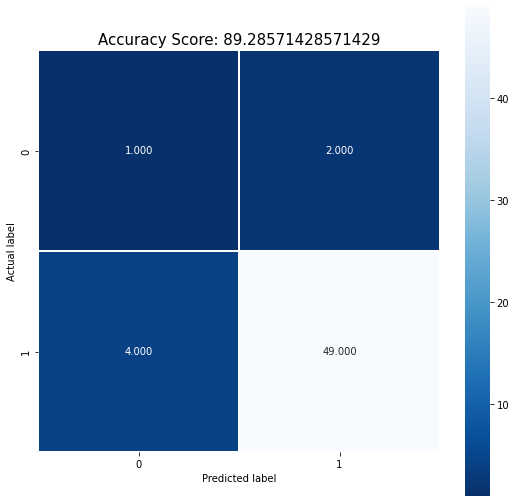

In [ ]:
#@title Putting All Together And Saving Text / Image plots 

VALIDATION_PERCENTAGE = 10 # the validation percentage from the tag folder in %

warnings.filterwarnings('ignore')
out_folder = os.path.join(CURR_DIR , 'outputs' , 'reports')

os.makedirs(out_folder , exist_ok=True)
text_hist_list = os.listdir(out_folder)

transform = preprocess
for idx , dir in enumerate(os.listdir(new_binary_directory)):
  text_lines = []  # tag name
  tag_name = dir.split('-binary')[0]
  text_lines.append("model: [ovr-LR]\n") 
  text_lines.append("task: binary-classification\n")
  text_lines.append(f"tag: [{tag_name}]\n\n")

  bin_dataset_dir  = os.path.join(new_binary_directory , dir)
  
  # tag-set , other-set sizes are here
  for folder in os.listdir(bin_dataset_dir): # the size of the other folder and tag folder 
    if folder != 'other':
      text_lines.append(f'tag-set-image-count: {len(os.listdir(os.path.join(bin_dataset_dir , folder)))}  \n')
    else:
      text_lines.append(f'other-set-image-count: {len(os.listdir(os.path.join(bin_dataset_dir , folder)))}  \n')
  
  if f'{dir}-confusionMatrix--LR.png' in text_hist_list: # To continue if stop happened for any reason
    print(f"Skipping {dir}")
    continue

  ## ==> Make the train , test features 
  dataset_dir  = os.path.join(new_binary_directory , dir)
  dataset = torchvision.datasets.ImageFolder(dataset_dir, transform)
  tagged_dataset_dir = os.path.join(TAGGED_IMGS , tag_name)

  idx_class_map = {}
  for idx , class_name in enumerate(dataset.classes): # adds the index and class name of this index 
    idx_class_map[idx] = class_name

  n = len(dataset)  # total number of examples
  n_tag = len(os.listdir(tagged_dataset_dir)) # length of the tag set to take 10% 
  n_test = int(0.1 * n)  # take ~10% for test

  n_tag_test = int(VALIDATION_PERCENTAGE/100 * n_tag) # number of image will be taken from the tagged class 
  
  if n_tag_test == 0 : # no zero for tagged image in test (must be from tagged class in test set)
    n_tag_test = 1
  
  print(f"Test images of tagged set  {n_tag_test}")

  # Make sure to have atleast 10% of the tagged class in the test set 
  if idx_class_map[0] != 'other':
    test_list  = [i for i in range(0 ,n_tag_test)] # take the first 10%
    test_list.extend([i for i in range(n_tag , n_tag+n_test-n_tag_test)])
    train_list = [i for i in range(n_tag_test ,n_tag)]
    train_list.extend([i for i in range( n_tag+n_test-n_tag_test , n)])
  else:
    test_list  = [i for i in range(n-n_tag_test ,n)] # take the first 10%
    test_list.extend([i for i in range(0, n_test-n_tag_test)])
    train_list = [i for i in range(n-n_tag , n-n_tag_test)]
    train_list.extend([i for i in range(n_test-n_tag_test , n-n_tag )])


  train_set    = torch.utils.data.Subset(dataset, train_list)
  test_set     = torch.utils.data.Subset(dataset, test_list)  
  print(f'Map index {idx_class_map}')

  try :  
    train_features, train_labels = get_features(train_set)
    test_features, test_labels = get_features(test_set)
  ## ==> Run Logistic regression 
    classifier = LogisticRegression(random_state=0, multi_class='ovr')
    classifier.fit(train_features, train_labels)
  except : 
    print(f"Problem with dir {dir}")
    continue
  
  # Add validation-tag-image-count  validation-other-image-count
  vld_tag_count , vld_other_count = from_labels_to_count(test_labels , idx_class_map)
  text_lines.append(f'validation-tag-image-count : {vld_tag_count}  \n')
  text_lines.append(f'validation-other-image-count : {vld_other_count}  \n\n')
  
  # Evaluate using the logistic regression classifier
  predictions = classifier.predict(test_features)
  accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
  print(f"Accuracy = {accuracy:.4f}")
  # adding accuracy to yhe text file 
  confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
  FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
  FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
  TP = np.diag(confusion_matrix)
  TN = confusion_matrix.sum() - (FP + FN + TP)
  ALL_SUM = FP + FN + TP + TN
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  text_lines.append(f'false-positive-rate: {FPR[0] :.4f}  \n')
  text_lines.append(f'false-negative-rate: {FNR[0] :.4f}  \n')
  text_lines.append(f'true-positive-rate : {TPR[0] :.4f}  \n')
  text_lines.append(f'true-negative-rate : {TNR[0] :.4f}  \n\n')
  text_lines.append(f'false-positive :  {FP[0]} out of {ALL_SUM[0]}  \n')
  text_lines.append(f'false-negative : {FN[0]}  out of {ALL_SUM[0]} \n')
  text_lines.append(f'true-positive : {TP[0]} out of {ALL_SUM[0]}  \n')
  text_lines.append(f'true-negative : {TN[0]} out of {ALL_SUM[0]}  \n\n')
  text_lines.append(f'>Accuracy : {accuracy:.4f}\n\n')
  text_lines.append(f"Classification Report : \n\n{classification_report(test_labels, predictions)}\n\n")
  text_lines.append(f"Index 0 is class {idx_class_map[0]}\n")
  text_lines.append(f"Index 1 is class {idx_class_map[1]}\n\n")

  plt.figure(figsize=(9,9))
  sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
  plt.title(all_sample_title, size = 15);
  plt_fig_path = os.path.join(out_folder , f'{dir}-confusionMatrix-LR.png')
  plt.savefig(plt_fig_path)

  tagged_folder_features = folder_to_featureList(tagged_dataset_dir)
  in_tag_tagged , out_tag_tagged = histogram_list( tagged_folder_features , classifier , idx_class_map)
  in_tag_rand , out_tag_rand = histogram_list( hist_folder_features , classifier , idx_class_map)

  graph = Pyasciigraph()
  for line in  graph.graph('in-distribution', in_tag_tagged):
    text_lines.append(f'{line} \n')
  text_lines.append('\n\n')
  graph = Pyasciigraph()
  for line in  graph.graph('out-distribution', in_tag_rand):
    text_lines.append(f'{line} \n')

  # making the text file for LR model
  text_file_path = os.path.join(out_folder ,f'model-ovr-logistic-regression-tag-{tag_name}-metric-acc-class_report.txt' )
  with open( text_file_path ,"w+" ) as f:
    f.writelines(text_lines)
    f.close()

  ###################################  SVM MODEL  ###################################
  
  ## ==> SVM 
  # Creating the SVM model
  
  model_ovo = SVC(decision_function_shape='ovo' , probability = True)
  # Fitting the model with training data
  model_ovo.fit(train_features, train_labels)
  # Making a prediction on the test set
  prediction = model_ovo.predict(test_features)

  text_lines = text_lines[0:7] # taking only the common part 
  text_lines[0] = "model : [svm-ovo]\n"

  # Evaluating the model
  acc_score  = accuracy_score(test_labels, prediction) * 100 
  confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
  FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
  FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
  TP = np.diag(confusion_matrix)
  TN = confusion_matrix.sum() - (FP + FN + TP)
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  text_lines.append(f'false-positive-rate: {FPR[0] :.4f}  \n')
  text_lines.append(f'false-negative-rate: {FNR[0] :.4f}  \n')
  text_lines.append(f'true-positive-rate : {TPR[0] :.4f}  \n')
  text_lines.append(f'true-negative-rate : {TNR[0] :.4f}  \n\n')
  text_lines.append(f'false-positive :  {FP[0]} out of {ALL_SUM[0]}  \n')
  text_lines.append(f'false-negative : {FN[0]}  out of {ALL_SUM[0]} \n')
  text_lines.append(f'true-positive : {TP[0]} out of {ALL_SUM[0]}  \n')
  text_lines.append(f'true-negative : {TN[0]} out of {ALL_SUM[0]}  \n\n')
  text_lines.append(f'>Accuracy : {acc_score:.4f}\n\n')
  text_lines.append(f"Classification Report : \n\n{classification_report(test_labels, predictions)}\n\n")
  text_lines.append(f"Index 0 is class {idx_class_map[0]}\n")
  text_lines.append(f"Index 1 is class {idx_class_map[1]}\n\n")

  in_tag_tagged , out_tag_tagged = histogram_list( tagged_folder_features , model_ovo , idx_class_map)
  in_tag_rand , out_tag_rand = histogram_list( hist_folder_features , model_ovo , idx_class_map)

  graph = Pyasciigraph()
  for line in  graph.graph('in-distribution', in_tag_tagged):
    text_lines.append(f'{line} \n')
  text_lines.append('\n\n')
  graph = Pyasciigraph()
  for line in  graph.graph('out-distribution', in_tag_rand):
    text_lines.append(f'{line} \n')
  
  text_file_path = os.path.join(out_folder ,f'model-ovr-svm-tag-{tag_name}-metric-acc-class_report.txt' )
  with open( text_file_path ,"w+" ) as f:
    f.writelines(text_lines)
    f.close()
  print(f"Finished {tag_name} tag")

    

In [ ]:
!pip freeze > requirements.txt 

In [ ]:
!cp -r /content/outputs/reports /content/drive/MyDrive/Brandon